## Import

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [3]:
import tensorflow as tf

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import save_model, load_model

from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten, Dropout
from keras.layers import LSTM, GRU, Bidirectional, TimeDistributed, Lambda, Bidirectional

from keras import backend as K

from tensorflow.keras.utils import pad_sequences

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam



## 사용 X

In [4]:
def create_dataset():
    X=[]
    y=[]

    folders = ['backhand', 'forehand', 'service', 'smash']
    for folder in folders:
        base_path = f'../keypoints/{folder}/'
        for csv_path in os.listdir(base_path):
            data = pd.read_csv(base_path + csv_path)
            
            features = data.loc[:, data.columns != 'class']

            X.append(features.to_numpy())
            y.append(data["class"].iloc[0])

    X = np.stack(X, axis=0)
    X = np.array(X)
    y = np.array(y)

    return X, y

In [128]:
# 데이터 좌우 대칭 -> x 값만 변화, y값 변화 없음
def revert_datasets(df):
    revert_data = df.copy()
    
    for feature in df.columns:
        if feature[-2:] == '_x':
            revert_data[feature] = 1 - df[feature]
    return revert_data

## 6 Classes Dataset

In [58]:
# 각 csv 파일 번호에 matching되는 motion
# 0 - 71: backhand2hands -> backhand
# 72 - 124: backhand
# 125 - 190: backhand_slice -> backhand
# 191 - 247: backhand_volley
# 248 - 306: forehand_flat -> forehand
# 307 - 355: forehand_openstands -> forehand
# 356 - 413: forehand_slice -> forehand
# 414 - 470: forehand_volley
# 471 - 539: flat_service -> service
# 540 - 600: kick_service -> service
# 601 - 650: slice_service -> service
# 651 - 704: smash

In [4]:
# 'backhand': 0, 'forehand': 1, 'service': 2, 'smash': 3, 'backhand_volley': 4, 'forehand_volley' : 5

sequence_length = 60

def create_dataset_6cls():
    X=[]
    y=[]

    folders = ['backhand', 'forehand', 'service', 'smash']
    for folder in folders:
        base_path = f'../keypoints/{folder}/'
        for csv_path in os.listdir(base_path):
            df = pd.read_csv(base_path + csv_path)
            df = df.drop(df.columns[2:10], axis=1) # ear와 eye에 관련된 column 제거

            # 'backhand_volley'
            if folder == 'backhand':
                if int(csv_path[9:-4]) >= 191 and int(csv_path[9:-4]) <= 247:
                    df.loc[df['class'] == 0, 'class'] = 4
            
            # 'forehand_volley'
            if folder == 'forehand':
                if int(csv_path[9:-4]) >= 414 and int(csv_path[9:-4]) <= 470:
                    df.loc[df['class'] == 1, 'class'] = 5

            # 60개씩 끊어서 저장
            num_rows = df.shape[0]
            num_batches = num_rows // sequence_length

            for i in range(num_batches):
                start_idx = i * sequence_length
                end_idx = (i + 1) * sequence_length
                
                data = df.iloc[start_idx : end_idx, :].reset_index(drop=True)

                features = data.loc[:, data.columns != 'class']
                X.append(features.to_numpy())
                y.append(data["class"].iloc[0])
                
    X = np.stack(X, axis=0)

    X = np.array(X)
    y = np.array(y)

    return X, y

In [8]:
# 'backhand': 0, 'forehand': 1, 'service': 2, 'smash': 3, 'backhand_volley': 4, 'forehand_volley' : 5

sequence_length = 60

def create_dataset_6cls():
    X=[]
    y=[]

    folders = ['backhand', 'forehand', 'service', 'smash']
    for folder in folders:
        base_path = f'../keypoints/{folder}/'
        for csv_path in os.listdir(base_path):
            df = pd.read_csv(base_path + csv_path)
            df = df.drop(df.columns[2:10], axis=1) # ear와 eye에 관련된 column 제거

            # 'backhand_volley'
            if folder == 'backhand':
                if int(csv_path[9:-4]) >= 191 and int(csv_path[9:-4]) <= 247:
                    df.loc[df['class'] == 0, 'class'] = 4
            
            # 'forehand_volley'
            if folder == 'forehand':
                if int(csv_path[9:-4]) >= 414 and int(csv_path[9:-4]) <= 470:
                    df.loc[df['class'] == 1, 'class'] = 5

            # 60개씩 끊어서 저장
            num_rows = df.shape[0]
            num_batches = num_rows - sequence_length + 1

            for i in range(num_batches):
                data = df.iloc[i : i+sequence_length, :].reset_index(drop=True)

                features = data.loc[:, data.columns != 'class']
                X.append(features.to_numpy())
                y.append(data["class"].iloc[0])
                
    X = np.stack(X, axis=0)

    X = np.array(X)
    y = np.array(y)

    return X, y

In [9]:
X, y = create_dataset_6cls()

In [10]:
print(X.shape)
print(y.shape)

(10419, 60, 26)
(10419,)


In [11]:
# Split dataset
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=123, stratify=y)

# One-hot Encoding
le = preprocessing.LabelEncoder()

y_train = le.fit_transform(y_train)
y_valid = le.fit_transform(y_valid)

num_classes = 6
y_train = to_categorical(y_train, num_classes=num_classes)
y_valid = to_categorical(y_valid, num_classes=num_classes)

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(7293, 60, 26)
(7293, 6)
(3126, 60, 26)
(3126, 6)


## 4 Classes dataset

In [87]:
sequence_length = 17

def create_revert_dataset():
    X=[]
    y=[]

    folders = ['backhand', 'forehand', 'service', 'smash']
    for folder in folders:
        base_path = f'../keypoints/{folder}/'
        for csv_path in os.listdir(base_path):
            df = pd.read_csv(base_path + csv_path)
            df = df.drop(df.columns[2:10], axis=1) # ear와 eye에 관련된 column 제거

            # 60개씩 끊어서 저장
            num_rows = df.shape[0]
            num_batches = num_rows - sequence_length + 1

            for i in range(num_batches):
                data = df.iloc[i : i+sequence_length, :].reset_index(drop=True)

                # 데이터 변환
                # revert_data = revert_datasets(df)

                # X.append(revert_data.values[1:])
                # y.append(revert_data['class'].values[0])
                
                features = data.loc[:, data.columns != 'class']
                X.append(features.to_numpy())
                y.append(data["class"].iloc[0])
    

                
    X = np.stack(X, axis=0)

    X = np.array(X)
    y = np.array(y)

    return X, y

In [88]:
X, y = create_revert_dataset()

In [89]:
print(X.shape)
print(y.shape)

(682, 50, 26)
(682,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

In [79]:
# Split dataset
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, shuffle=True)

In [80]:
# One-hot Encoding
le = preprocessing.LabelEncoder()

y_train = le.fit_transform(y_train)
y_valid = le.fit_transform(y_valid)

num_classes = 4
y_train = to_categorical(y_train, num_classes=num_classes)
y_valid = to_categorical(y_valid, num_classes=num_classes)

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

IndexError: index 4 is out of bounds for axis 1 with size 4

## GRU

In [12]:
# Model 정의
model = Sequential([
    GRU(64, dropout=0.1, input_shape=(sequence_length, 26)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                17664     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 22,470
Trainable params: 22,342
Non-trainable params: 128
__________________________________________________

In [14]:
# checkpoint = ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=0, save_best_only=True, mode='auto')
checkpoint = ModelCheckpoint('../models/model11.h5', verbose=0, save_best_only=True)
# scheduler = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=5, verbose=1, mode='auto')

batch_size = 32
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs=300,
    batch_size=batch_size,
    callbacks=[checkpoint]
)

Epoch 1/300
228/228 [==============================] - 8s 11ms/step - loss: 1.4938 - acc: 0.4316 - val_loss: 1.4860 - val_acc: 0.4485
Epoch 2/300
228/228 [==============================] - 2s 7ms/step - loss: 0.9989 - acc: 0.6464 - val_loss: 1.4483 - val_acc: 0.4632
Epoch 3/300
228/228 [==============================] - 2s 7ms/step - loss: 0.8670 - acc: 0.6879 - val_loss: 1.3276 - val_acc: 0.5691
Epoch 4/300
228/228 [==============================] - 2s 7ms/step - loss: 0.7786 - acc: 0.7144 - val_loss: 1.0841 - val_acc: 0.6244
Epoch 5/300
228/228 [==============================] - 1s 7ms/step - loss: 0.7494 - acc: 0.7227 - val_loss: 1.1604 - val_acc: 0.6081
Epoch 6/300
228/228 [==============================] - 2s 7ms/step - loss: 0.6963 - acc: 0.7469 - val_loss: 0.5203 - val_acc: 0.7978
Epoch 7/300
228/228 [==============================] - 2s 7ms/step - loss: 0.6771 - acc: 0.7541 - val_loss: 0.8989 - val_acc: 0.6679
Epoch 8/300
228/228 [==============================] - 2s 7ms/step -

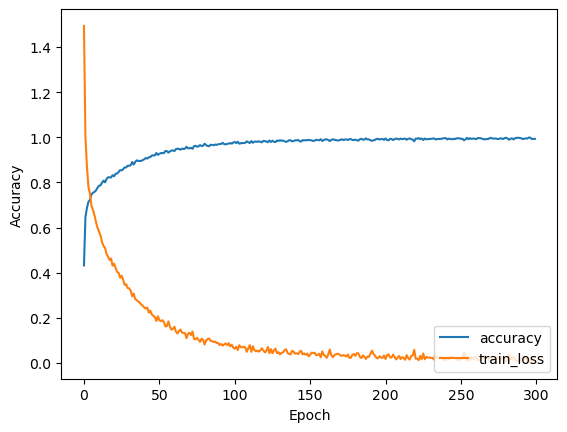

In [15]:
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['loss'], label = 'train_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

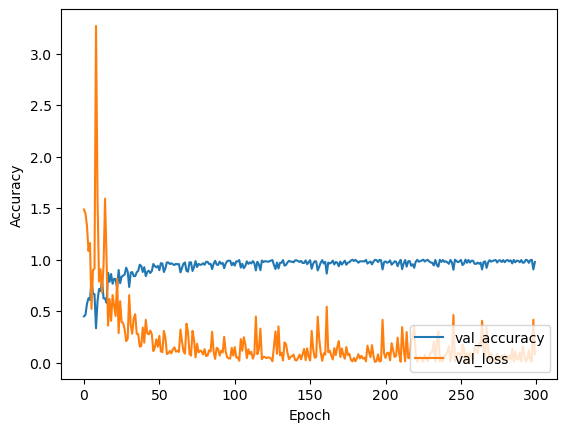

In [16]:
plt.plot(history.history['val_acc'], label='val_accuracy')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [17]:
loss, accuracy = model.evaluate(X_valid, y_valid)
print(f"Accuracy on validation dataset = {accuracy}")

model.load_weights('../models/model11.h5')

loss, accuracy = model.evaluate(X_valid, y_valid)
print(f"Accuracy on validation dataset = {accuracy}")

98/98 [==============================] - 0s 4ms/step - loss: 0.0822 - acc: 0.9747
Accuracy on validation dataset = 0.9747281074523926
98/98 [==============================] - 0s 3ms/step - loss: 0.0058 - acc: 0.9984
Accuracy on validation dataset = 0.9984005093574524


In [18]:
# 모델 저장
model.save('../models/gru/gru64.h5')

## LSTM

In [54]:
units = 128
model = Sequential([
    Dropout(0.1, input_shape=(sequence_length, 26)),
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.5), merge_mode='concat'),
    TimeDistributed(Dropout(0.1)),
    TimeDistributed(Dense(64, activation='relu')),
    TimeDistributed(Dense(6, activation='softmax')),
    Lambda(function=lambda x: K.mean(x, axis=1))
])

In [19]:
model = Sequential([
    LSTM(64, dropout=0.1, input_shape=(sequence_length, 26), return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),
    # LSTM(64, dropout=0.1, return_sequences=False),
    # BatchNormalization(),
    # Dropout(0.3),
    Dense(32, activation='relu'), # , kernel_regularizer=l2(0.001)
    Dense(6, activation='softmax')
])

In [20]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                23296     
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 6)                 198       
                                                                 
Total params: 25,830
Trainable params: 25,702
Non-trainable params: 128
________________________________________________

In [21]:
checkpoint = ModelCheckpoint('../models/model12.h5', verbose=1, save_best_only=True, period=1)
# scheduler = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=5, verbose=1, mode='auto')

batch_size = 16

history = model.fit(
    X_train,
    y_train,
    epochs=300,
    batch_size=batch_size,
    validation_data=(X_valid, y_valid),
    callbacks=[checkpoint]
)

Epoch 1/300
455/456 [============================>.] - ETA: 0s - loss: 1.1773 - accuracy: 0.5705
Epoch 1: val_loss improved from inf to 1.75284, saving model to ../models\model12.h5
456/456 [==============================] - 6s 10ms/step - loss: 1.1775 - accuracy: 0.5703 - val_loss: 1.7528 - val_accuracy: 0.4002
Epoch 2/300
450/456 [============================>.] - ETA: 0s - loss: 0.8836 - accuracy: 0.6849
Epoch 2: val_loss improved from 1.75284 to 0.79158, saving model to ../models\model12.h5
456/456 [==============================] - 3s 8ms/step - loss: 0.8834 - accuracy: 0.6850 - val_loss: 0.7916 - val_accuracy: 0.6894
Epoch 3/300
454/456 [============================>.] - ETA: 0s - loss: 0.8049 - accuracy: 0.7101
Epoch 3: val_loss did not improve from 0.79158
456/456 [==============================] - 3s 8ms/step - loss: 0.8050 - accuracy: 0.7099 - val_loss: 0.8370 - val_accuracy: 0.6875
Epoch 4/300
453/456 [============================>.] - ETA: 0s - loss: 0.7247 - accuracy: 0.74

In [30]:
loss, accuracy = model.evaluate(X_valid, y_valid)
print(f"Accuracy on validation dataset = {accuracy}")

model.load_weights('../models/lstm/model12.h5')

loss, accuracy = model.evaluate(X_valid, y_valid)
print(f"Accuracy on validation dataset = {accuracy}")

98/98 [==============================] - 1s 5ms/step - loss: 0.0089 - accuracy: 0.9968
Accuracy on validation dataset = 0.9968010187149048
98/98 [==============================] - 0s 3ms/step - loss: 0.0089 - accuracy: 0.9968
Accuracy on validation dataset = 0.9968010187149048


In [55]:
model.save('../models/model_2lstm_seq50.h5')

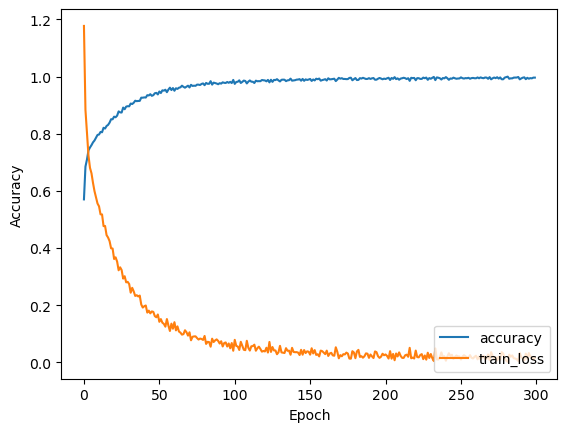

In [24]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label = 'train_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

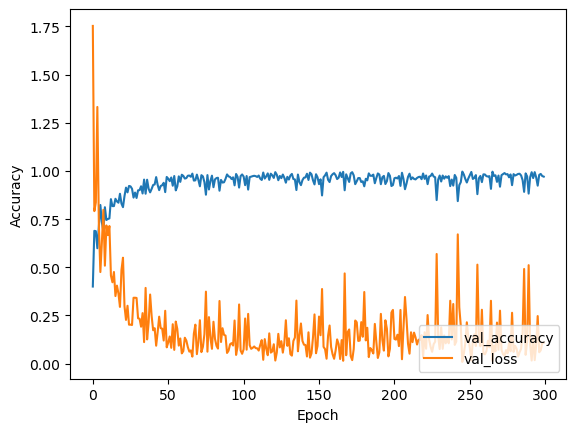

In [26]:
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [27]:
model.save('models/lstm/1lstm64.h5')